If you are looking at this notebook on Github, you may want to switch to the [Jupyter notebook viewer][1] instead.

[1]: https://nbviewer.jupyter.org/github/chen-szuyu-cody/portfolio/blob/master/Project/wids_datathon_2020/Predict%20encounter%20death%20probability%20using%20XGBoost.ipynb#data_preprocessing

# Predicting patients death probability by using XGBoost
#### Conduct Ensemble Learning - eXtreme Gradient Boosting (XGBoost) to preict death probability of patients from different intense care unit (ICU) in an one year timeframe.

## Brief introduction of XGBoost

> The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use xgboost. — Tianqi Chen


Reference: 

- [A Gentle Introduction to XGBoost for Applied Machine Learning][0]
- [CatBoost vs. Light GBM vs. XGBoost][1]



[0]: https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

[1]: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

<h4> There are few things need to pay attention to:</h4>
    
- XGBoost **cannot handle categorical features by itself**, it only accepts numerical values similar to Random Forest. Therefore one has to perform various encodings like label encoding, or one-hot encoding before supplying categorical data to XGBoost.

<h1>Analysis Outline:</h1>

- [Data Pre-processing](#data_preprocessing)
- [Data Cleaning](#data_cleaning)
- [Data Modeling](#data_modeling)
- [Model Performance evaluation](#evaluation)
- [Predicting Testing Data](#prediction)
- [Result](#result)

# <a id="data_preprocessing">Data Pre-processing</a>

#### Loading Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)

# !python -m pip install --upgrade pip
import os
# !pip uninstall numpy
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from xgboost import plot_tree

%pylab inline
from collections import defaultdict

import seaborn as sns
from matplotlib.colors import rgb2hex, colorConverter
from scipy.cluster.hierarchy import dendrogram, linkage

pd.set_option('display.max_columns', 1000)
pd.set_option('max_info_columns', 91713)
np.random.seed(566)
pd.set_option('display.max_rows', 92000)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

#### Read datasets

In [2]:
### Assign dataset path
path_data = 'C:/Users/Cody_Black/JupyterNotebook/Dataset'
os.chdir(path_data)
### Read the dataset
train = pd.read_csv("../Dataset/training_v2.csv")
test = pd.read_csv("../Dataset/unlabeled.csv")
dictionary = pd.read_csv("../Dataset/WiDS Datathon 2020 Dictionary.csv")

# <a id="data_cleaning">Data Cleaning</a>

Process data points:
- Set index column as encounter_id
- Exclude highly correlated columns (threshold 0.9)
- Modify certian columns:
    - pre_icu_los_days: adjuct negative value
    - age: segament into 7 groups
- Fill in missing values for certain columns:
    - height
    - weight
    - bmi
- Change categorical data into dummy variables

In [3]:
def data_processing(df, change_to_bool, change_to_cat, excludeColumns):
    '''
    Process data points:
    - Set index column as encounter_id
    - Exclude highly correlated columns (threshold 0.9)
    - Modify certian columns:
        - pre_icu_los_days: adjuct negative value
        - age: segament into 7 groups
    - Fill in missing values for certain columns:
        - height
        - weight
        - bmi
    - Change categorical data into dummy variables
    '''
    ### set encounter_id as index
    df.set_index('encounter_id', inplace=True)
    
    ### Exclude collinear (highly correlated) features 
      # by dropping columns with correlations above threshold
    threshold = 0.9 # Threshold for removing correlated variables
    corr_matrix = df.drop(columns='hospital_death').corr().abs() # Absolute value correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # Upper triangle of correlations
    to_drop = set( [column for column in upper.columns if any(upper[column] > threshold)] )
    excludeColumns = excludeColumns.union(to_drop) #save it to the excusion list
    
    ### Modify negative value to positive of pre_icu_los_days
    df['pre_icu_los_days'] = abs(df['pre_icu_los_days'])
    
    ### Missing value
    ## fillna in height/weight/bmi
    df['height'] = df.groupby(['ethnicity', 'gender'])['height'].apply(lambda x: x.fillna(x.median()))   
    df['weight'] = df.groupby(['ethnicity', 'gender', 'height'])['weight'].apply(lambda x: x.fillna(x.median()))    
    df['bmi'] = df.apply( lambda x: x['weight']/(0.01 * x['height'])**2 if np.isnan(x['bmi']) else x['bmi'], axis=1)
    
    ### Segment age
    df['age'] = df['age'].fillna(-1)
    bins = [-1, 0, 20, 40, 60, 80, 100]
    group_names = ['NANN', '0-20', '20-39', '40-59', '60-79', '80-99']
    df['age'] = pd.cut(df['age'], bins, labels=group_names)

    ### Change factor type to category and insert NANN category
    for col in change_to_cat:
        df[col] = df[col].fillna('NANN')
        df[col] = df[col].astype('category')

    ### Transforming categorical variables into dummy variables
    df = pd.get_dummies(df)  
        
    return df, excludeColumns

###　Define lists of columns to be transformed
change_to_bool = ['hospital_death', 'elective_surgery', 'readmission_status',
                  'apache_post_operative', 'arf_apache',
                  'gcs_unable_apache', 'intubated_apache',
                  'ventilated_apache', 'aids', 'cirrhosis',
                  'diabetes_mellitus', 'hepatic_failure',
                  'immunosuppression', 'leukemia', 'lymphoma',
                  'solid_tumor_with_metastasis'] ## columns will transform to boolin type
change_to_cat = ['ethnicity', 'age', 'gender', 'hospital_admit_source',
                 'icu_admit_source', 'icu_stay_type', 'icu_type',
                 'apache_3j_bodysystem', 'apache_2_bodysystem'] ## columns will transform to categorical type

excludeColumns = ['hospital_death', 'readmission_status', 'patient_id'] ## Predefine unwanted columns


### Conduct function data_processing
train, excludeColumns = data_processing(train, change_to_bool, change_to_cat, set(excludeColumns))

# <a id="data_modeling">Data Modeling</a>

#### Split dataset into training and validation data

In [4]:
### Generate predictors and outcome variable for model usage
predictors = [s for s in train.columns if s not in excludeColumns]
outcome = 'hospital_death'
X = train[predictors]
y = train[outcome]

### Split dataset into training and testing
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state = 2020)

y_train = np.array(y_train.astype(np.int32)).reshape((-1,))
y_valid = np.array(y_valid.astype(np.int32)).reshape((-1,))

#### Set parameters for XGBoost model and train the model

In [5]:
### Set parameters for XGBoost model
params = {
    'class_weight'     : 'balanced',
    'boosting_type'    : 'gbdt',
    'num_leaves'       : 30,
    'learning_rate'    : 0.008,
    'subsample_for_bin': 20000,
    'min_child_samples': 20,
    'reg_alpha'        : 0.3,
    'reg_lambda'       : 0.5,
    'colsample_bytree' : 0.4,
    'scale_pos_weight' : 1,
    'subsample'        : 0.8,
    'objective'        : 'binary:logistic', 
    'n_estimators'     : 5000, 
    'max_depth'        : 4, 
    'gamma'            : 10,
    'random_state'     : 50
}

xgb_model_1 = xgb.XGBClassifier(**params) # Build XGBoost model
eval_set = [(X_train, y_train), (X_valid, y_valid)] # Set evaluation object
# Train XGboost model
%time xgb_model_1.fit(X_train, y_train, eval_metric=["error", "logloss", 'auc'], early_stopping_rounds=4000, eval_set=eval_set, verbose=200)

[0]	validation_0-error:0.077431	validation_0-logloss:0.686983	validation_0-auc:0.795538	validation_1-error:0.078808	validation_1-logloss:0.687238	validation_1-auc:0.789862
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 4000 rounds.
[200]	validation_0-error:0.070859	validation_0-logloss:0.258298	validation_0-auc:0.885263	validation_1-error:0.072441	validation_1-logloss:0.26127	validation_1-auc:0.873664
[400]	validation_0-error:0.068984	validation_0-logloss:0.200878	validation_0-auc:0.894316	validation_1-error:0.071002	validation_1-logloss:0.207215	validation_1-auc:0.879754
[600]	validation_0-error:0.067385	validation_0-logloss:0.186972	validation_0-auc:0.902386	validation_1-error:0.069432	validation_1-logloss:0.196309	validation_1-auc:0.884385
[800]	validation_0-error:0.06564	validation_0-logloss:0.180481	validation_0-auc:0.908664	validation_1-error:0.06869	validation_1-logloss:0.19231	val

XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbdt',
              class_weight='balanced', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.4, gamma=10, learning_rate=0.008,
              max_delta_step=0, max_depth=4, min_child_samples=20,
              min_child_weight=1, missing=None, n_estimators=5000, n_jobs=1,
              nthread=None, num_leaves=30, objective='binary:logistic',
              random_state=50, reg_alpha=0.3, reg_lambda=0.5,
              scale_pos_weight=1, seed=None, silent=None, subsample=0.8,
              subsample_for_bin=20000, verbosity=1)

# <a id="evaluation">Evaluate Model Performance</a>

## Data Vidualization

### Plot trees

#### We could see the top few important features in the model including <code>d1_lactate_max</code>, <code>gcs_motor_apache</code>, and <code>apache_3j_diagnosis</code>.

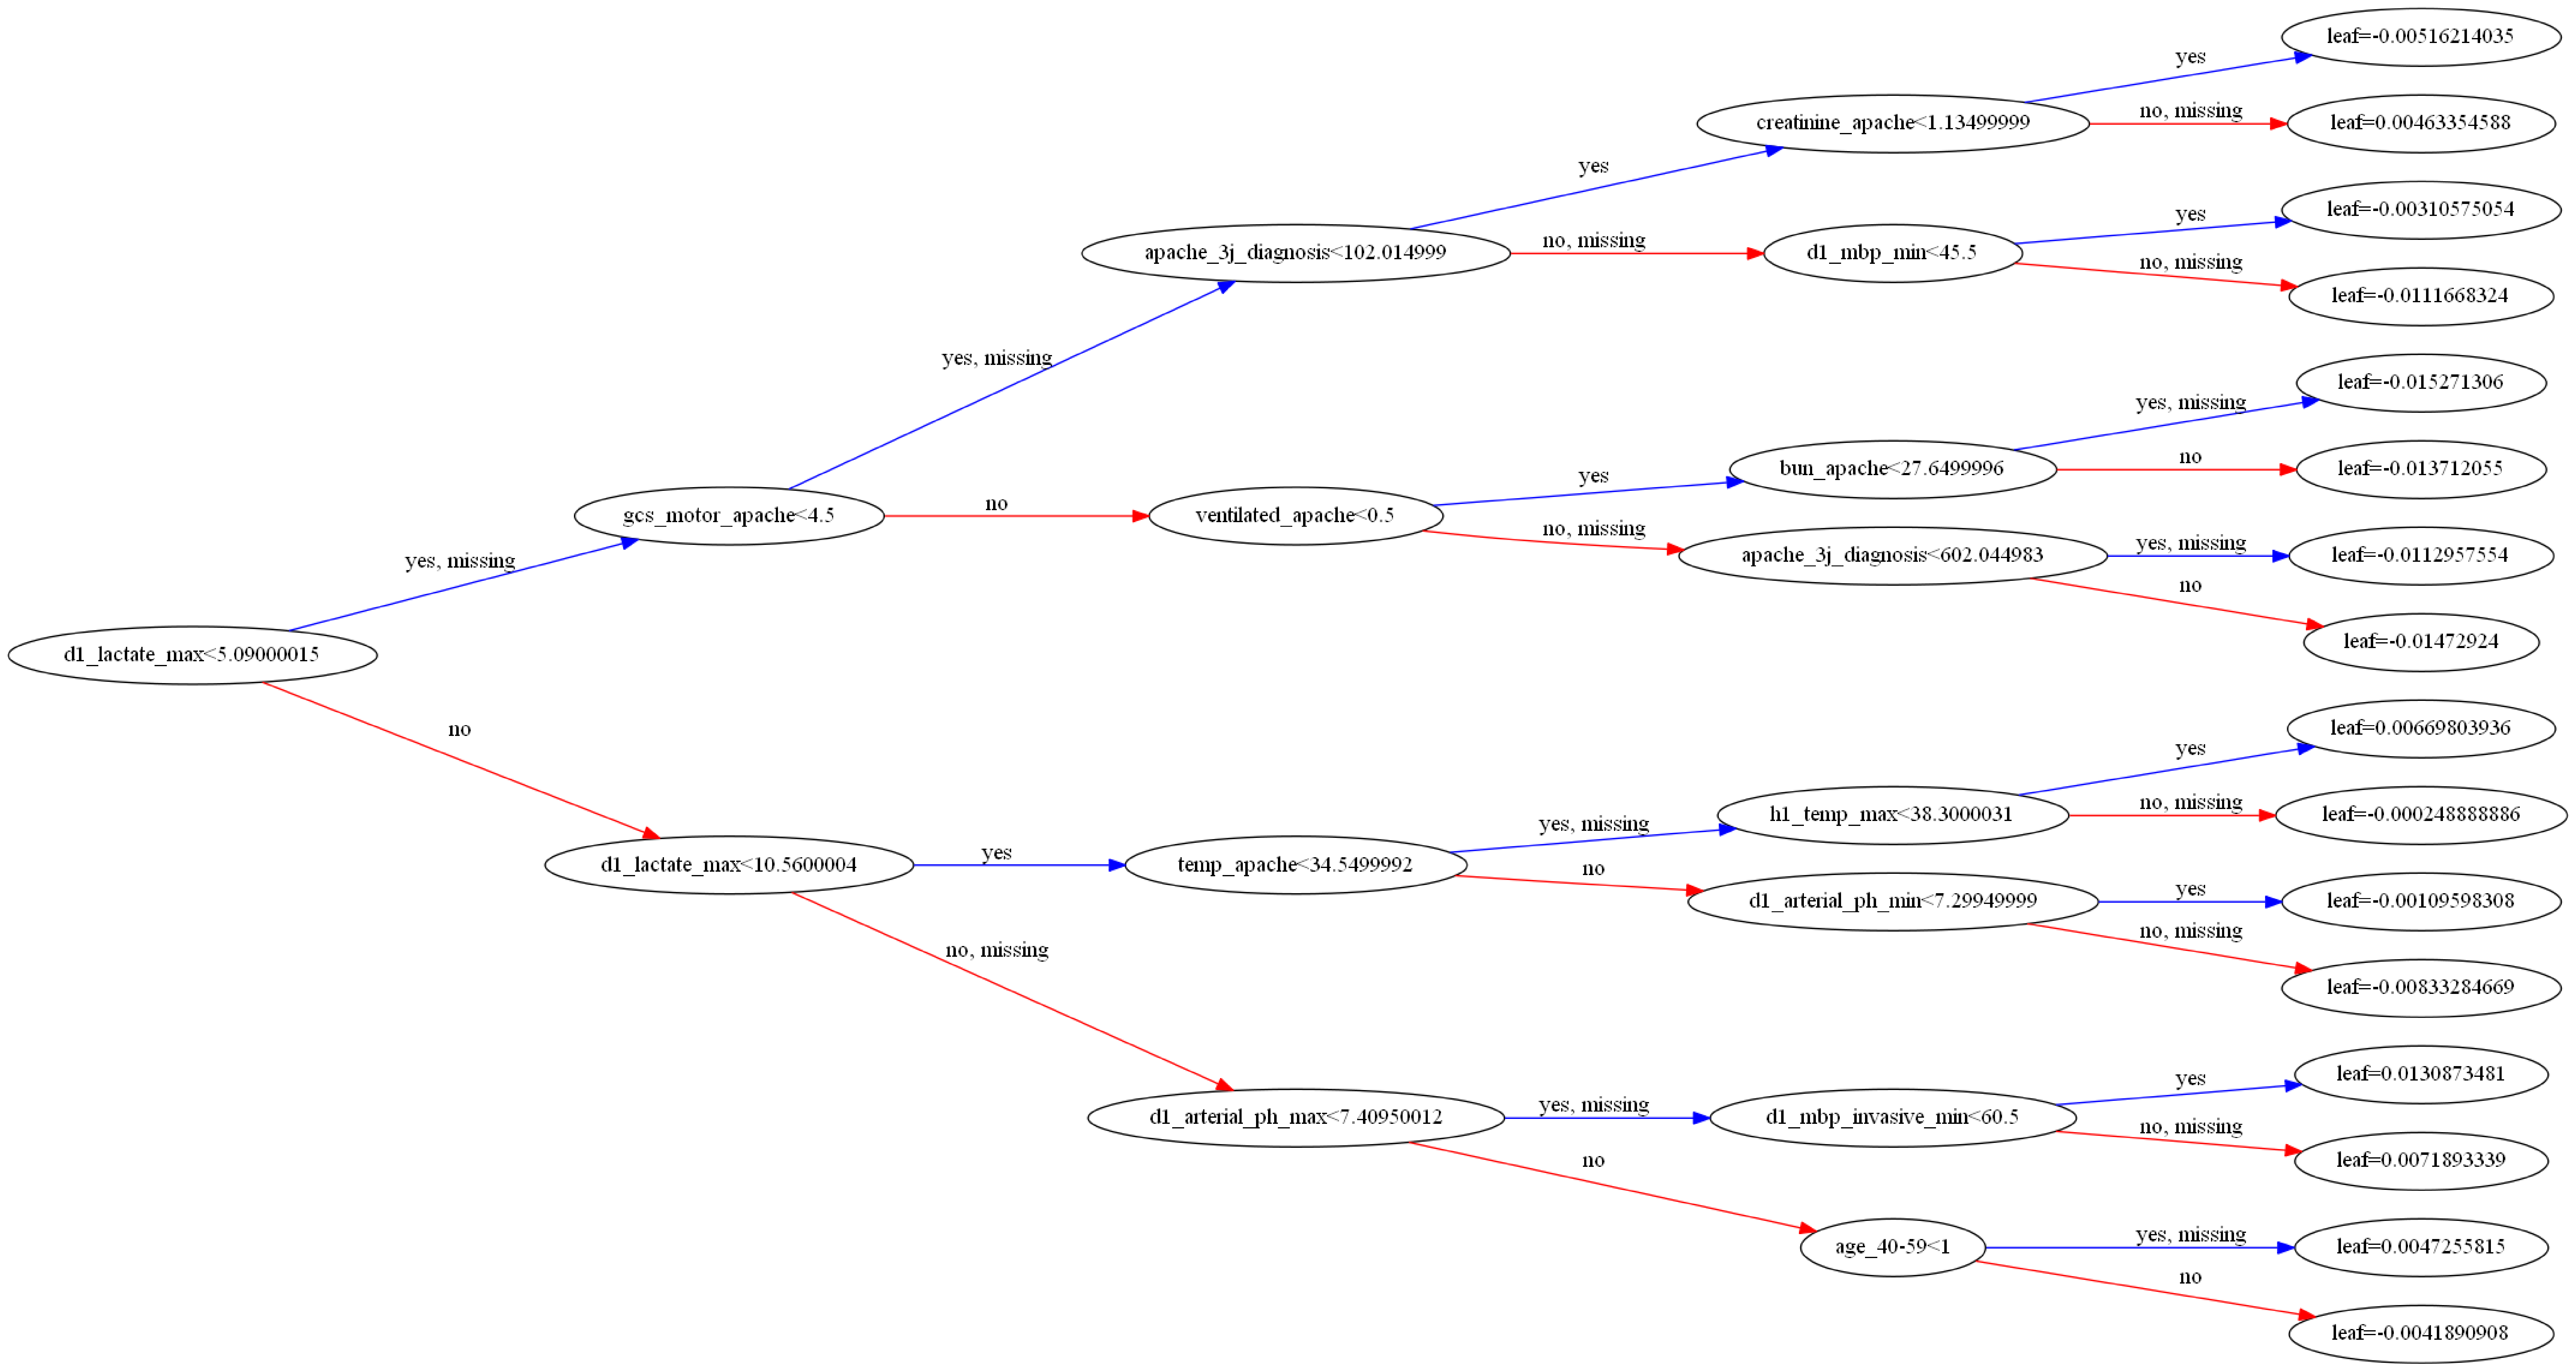

In [16]:
###  plot single tree
xgb.plot_tree(xgb_model_1, num_trees=0, rankdir='LR')#, num_trees=2
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show();
# fig.savefig('tree.png')

### Plot performance metrics

We could see that the training and validation dataset have a huge gap(**High Vairance**). The validation data's highest auc score is **0.900528** at the 5000 round.

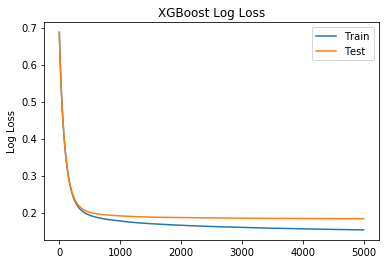

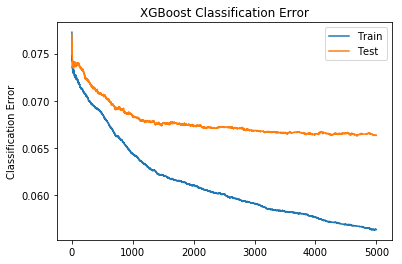

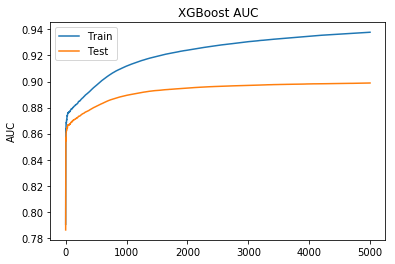

In [122]:
# retrieve performance metrics
results = xgb_model_1.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
fig.set_size_inches(6, 4.5)
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
fig.set_size_inches(6, 4.5)
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

# plot auc
fig, ax = pyplot.subplots()
fig.set_size_inches(6, 4.5)
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()

#### View the important feature from XGBoost model

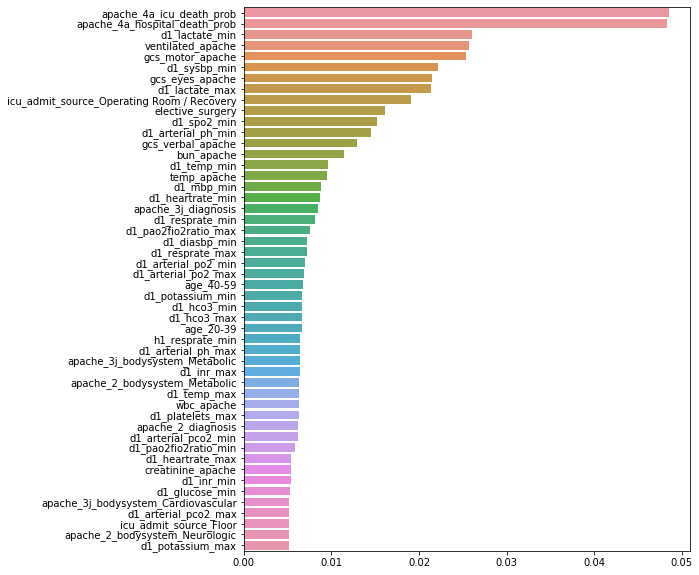

In [17]:
## Plot feature importance
feat_imp = pd.Series(xgb_model_1.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(8,10))
ax = sns.barplot(x=feat_imp.nlargest(50).values, y=feat_imp.nlargest(50).keys())

# <a id="prediction">Predicting Testing Data</a>

In [18]:
def data_processing_test(df, change_to_bool, change_to_cat, excludeColumns):
    
    ## set encounter_id as index
    df.set_index('encounter_id', inplace=True)

    ## Modify negative value to positive of pre_icu_los_days
    df['pre_icu_los_days'] = abs(df['pre_icu_los_days'])
    
    ### Missing value ###
    ## fillna in height/weight/bmi
    df['height'] = df.groupby(['ethnicity', 'gender'])['height'].apply(lambda x: x.fillna(x.median()))   
    df['weight'] = df.groupby(['ethnicity', 'gender', 'height'])['weight'].apply(lambda x: x.fillna(x.median()))    
    df['bmi'] = df.apply( lambda x: x['weight']/(0.01 * x['height'])**2 if np.isnan(x['bmi']) else x['bmi'], axis=1)
    
    ## Segment age
    df['age'] = df['age'].fillna(-1)
    bins = [-1, 0, 20, 40, 60, 80, 100]
    group_names = ['NANN', '0-20', '20-39', '40-59', '60-79', '80-99']
    df['age'] = pd.cut(df['age'], bins, labels=group_names)

    ## Change factor type to category and insert NANN category
    for col in change_to_cat:
        df[col] = df[col].fillna('NANN')
        df[col] = df[col].astype('category')


    ### Transforming categorical variables into dummy variables
    df = pd.get_dummies(df)  
        
    return df


### Data preprocessing
test = data_processing_test(test, change_to_bool, change_to_cat, excludeColumns)

## Make sure testing data has same variables as training data
cols_when_model_builds  = xgb_model_1.get_booster().feature_names
X_test = test
X_test['hospital_admit_source_Observation'] = np.nan
X_test = X_test[cols_when_model_builds]

In [19]:
########## prediction of unlabeled data #############
%time y_pred_unlabeled = xgb_model_1.predict_proba(X_test)[:,1]
data_to_submit = pd.DataFrame({
    'encounter_id':test.index,
    'hospital_death':y_pred_unlabeled
})

data_to_submit.to_csv('csv_to_submit_0207_0322.csv', index = False)

Wall time: 20.5 s


# <a id="result">Result</a>

## The final result has a 90.68% AUC score on Kaggle

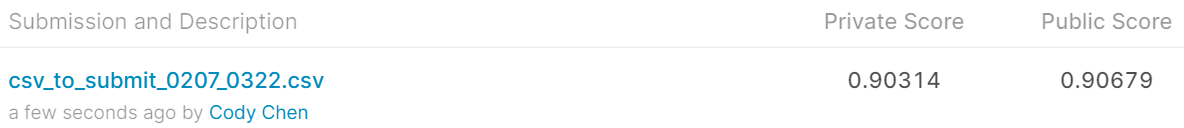

<img src="C:/Users/Cody_Black/JupyterNotebook/Dataset/image/0207_0304_kaggle_auc.PNG">
![alt text](0207_0304_kaggle_auc.PNG)

#### Save model to pick file

In [6]:
import pickle
# save model to file
pickle.dump(xgb_model_1, open("xgb_model_020720_0322.pickle.dat", "wb"))

# load model from file
# loaded_model = pickle.load(open("xgb_model_020720.pickle.dat", "rb"))